In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

## Train data

In [2]:
L = 24
path = ''
df = pd.read_csv(f"{path}results/p4_L{L}_cut_train_enc1.csv").loc[:,'T':]
df.head()

,T,0,1,2,3,4,5,6,7,8,...,567,568,569,570,571,572,573,574,575,Y
0,0.500239,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
1,0.500239,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,0.500239,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,0.500239,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
4,0.500239,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


In [3]:
to_ = str(L**2-1)

permute = df.sample(n=len(df),random_state=1).reset_index(drop=True)
train_size, valid_size, test_size = 0.9, 0.1, 0.0

train = permute[:int(len(permute)*train_size)]
valid = permute[int(len(permute)*train_size):int(len(df)*(train_size+valid_size))]
test = permute[int(len(permute)*(train_size+valid_size)):]

X_train = torch.Tensor(train.loc[:,'0':to_].to_numpy()).float()
Y_train = torch.Tensor(train.loc[:,'Y'].to_numpy()).long()
T_train = torch.Tensor(train.loc[:,'T'].to_numpy())

X_valid = torch.Tensor(valid.loc[:,'0':to_].to_numpy()).float()
Y_valid = torch.Tensor(valid.loc[:,'Y'].to_numpy()).long()
T_valid = torch.Tensor(valid.loc[:,'T'].to_numpy())

X_test = torch.Tensor(test.loc[:,'0':to_].to_numpy()).float()
Y_test = torch.Tensor(test.loc[:,'Y'].to_numpy()).long()
T_test = torch.Tensor(test.loc[:,'T'].to_numpy())


X_train = X_train.reshape(-1,1,L,L)
X_valid = X_valid.reshape(-1,1,L,L)
X_test = X_test.reshape(-1,1,L,L)


X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

(torch.Size([39600, 1, 24, 24]),
 torch.Size([39600]),
 torch.Size([4400, 1, 24, 24]),
 torch.Size([4400]),
 torch.Size([0, 1, 24, 24]),
 torch.Size([0]))

## Test data

In [4]:
tc = 1/(np.log(1+4**0.5)) ### 4-Potts
df = pd.read_csv(f"{path}results/p4_L{L}_cut_test_enc1.csv").loc[:,'T':]     #
df_4p = df.sample(n=len(df), random_state=1).reset_index(drop=True)
df_4p.tail()

,T,0,1,2,3,4,5,6,7,8,...,567,568,569,570,571,572,573,574,575,Y
66995,0.520239,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
66996,0.900239,1.0,-0.5,0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,0
66997,0.895539,-0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,-0.5,1.0,1.0,1.0,1.0,1.0,1.0,0
66998,0.860239,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,-1.0,-1.0,0
66999,1.200239,0.5,0.5,-1.0,-1.0,0.5,-0.5,-1.0,-0.5,-0.5,...,0.5,0.5,0.5,-0.5,-0.5,-1.0,-1.0,-1.0,0.5,1


In [5]:
X_test = torch.Tensor(df_4p.loc[:,'0':to_].to_numpy()).float()
Y_test = torch.Tensor(df_4p.loc[:,'Y'].to_numpy()).long()
T_test = torch.Tensor(df_4p.loc[:,'T'].to_numpy())
X_test = X_test.reshape(-1,1,L,L)

X_test.shape, Y_test.shape, T_test.shape

(torch.Size([67000, 1, 24, 24]), torch.Size([67000]), torch.Size([67000]))

## NN struct

In [6]:
## Construct NN

class ConvNN(torch.nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=2, padding=0, stride=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.fc1   = torch.nn.Linear(int(L/4*L/4*64), 64)
        self.act2  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(64, 2)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool1(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act2(x)
        x = self.fc2(x)
        return x
    
convnet = ConvNN()

In [7]:
### If u have GPU-device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
convnet = convnet.to(device)

loss = torch.nn.CrossEntropyLoss()       ### Loss CE
# loss = torch.nn.BCEWithLogitsLoss()    ### Loss BCE
optimizer = torch.optim.Adam(convnet.parameters(), lr=1.0e-4)
m = torch.nn.Softmax(dim=1)

Epoch: 	 0 | curr:	 1.0 | best: 	 1.0


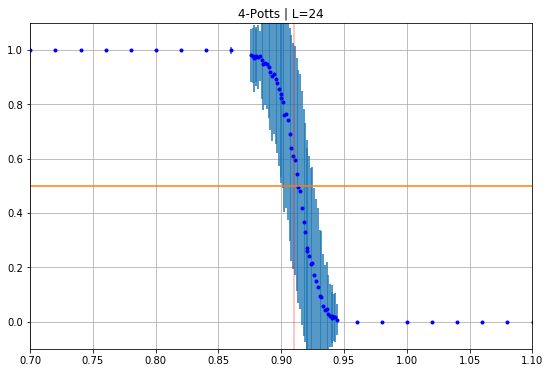

Epoch: 	 1 | curr:	 1.0 | best: 	 1.0


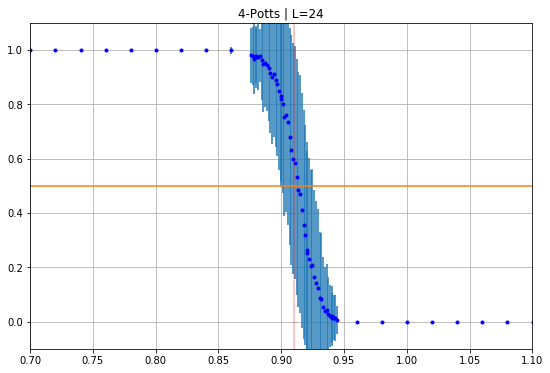

Epoch: 	 2 | curr:	 1.0 | best: 	 1.0


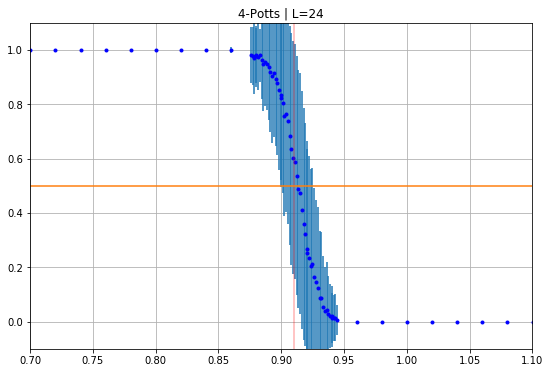

In [11]:
batch_size = 12
np.random.seed(1234)

test_accuracy_history = []
test_loss_history = []
best = 0

X_valid = X_valid.to(device)
Y_valid = Y_valid.to(device)

X_test = X_test.to(device)
T_test = T_test.to(device)

for epoch in range(3):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        Y_batch = Y_train[batch_indexes].to(device)
        
        preds = convnet.forward(X_batch) 
        
        loss_value = loss(preds, Y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = convnet.forward(X_valid)
    test_loss_history.append(loss(test_preds, Y_valid).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == Y_valid).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    if accuracy > best:
        best = accuracy
    
    print(f"Epoch: \t {epoch} | curr:\t {accuracy} | best: \t {best}")
    mean_, std_ = {},{}
    for T in T_test.unique():
        test_shape1 = X_test.reshape(-1,L*L)
        test_set = test_shape1[T_test == T].reshape(-1,1,L,L)
        preds = convnet.forward(test_set)
        probas = m(preds)[:,0]
        mean_[T] = np.mean(probas.data.cpu().numpy())
        std_[T] = np.std(probas.data.cpu().numpy())

    axis_x = [i.item() for i in mean_.keys()]
    axis_yf = [i.item() for i in mean_.values()]
    axis_yf_err = [i.item() for i in std_.values()]

    plt.figure(figsize=(9,6))
    plt.title(f"4-Potts | L={L}")
    plt.plot(axis_x, axis_yf, '.', c='blue')
    plt.errorbar(axis_x, axis_yf, yerr=axis_yf_err, fmt='none')
    plt.axvline(tc, 0, 1, c='r', label='T_c', alpha=0.3)
    plt.plot(axis_x, [0.5 for i in range(len(axis_x))], '-')
    plt.grid(True)
    plt.xlim((0.7, 1.1))
    plt.ylim((-.1, 1.1))
    plt.show()

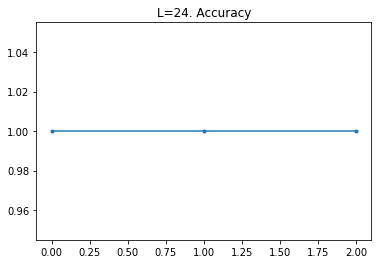

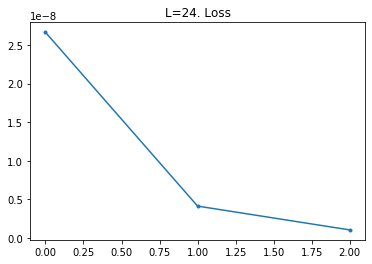

In [12]:
plt.plot(test_accuracy_history,'.-')
plt.title(f'L={L}. Accuracy')
plt.show()
plt.plot(test_loss_history, '.-')
plt.title(f'L={L}. Loss')
plt.show()